In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import scipy.signal as signal

In [2]:
import sipm.sipm as sipm
import sipm.dataset as ds
import sipm.functions as func

In [3]:
import importlib
importlib.reload(sipm)
importlib.reload(ds)
importlib.reload(func)

<module 'sipm.functions' from '/home/aj9512/sipm-analysis/sipm/functions.py'>

In [4]:
plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [14]:
data = {}
for i in range(20):
    print(i)
    data[i] = ds.Dataset(f"2022-11-09/2022-11-09_volt_65_pos_bottom_light_scintillation_coinc_111_cond_with_gamma_high_stat/{i}/", channels=[0,1,2,3])
    data[i].analyze(num_events=10000, clear=True, combine=True)

0


In [12]:
count = 0
sum_int = []
for i in range(5):
    if len(data[i].sum.integral)==0:
        continue
    if count == 0:
        sum_int = np.array(data[i].sum.integral)
    else:
        sum_int = np.concatenate((sum_int, np.array(data[i].sum.integral)))
    count += 1

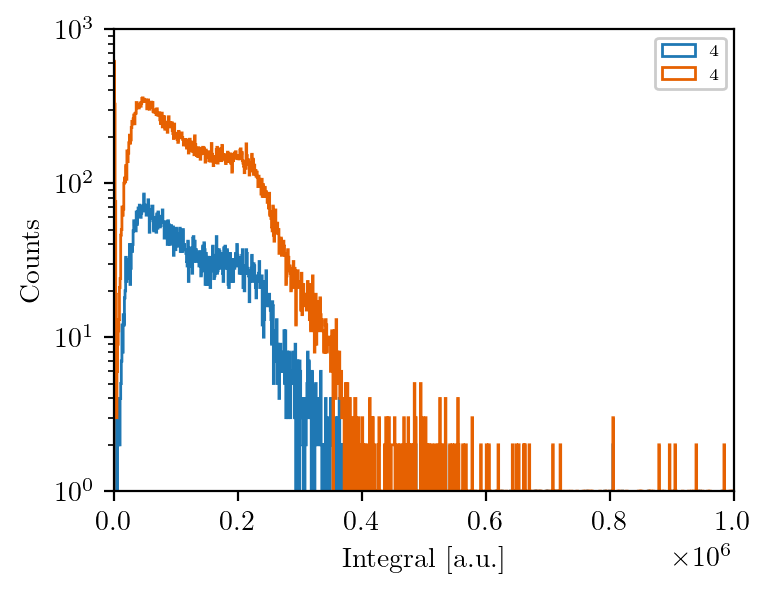

In [13]:
plt.figure()
plt.hist(data[i].sum.integral, bins=np.linspace(0,1000000,1000), histtype='step', label=f'{i}')
plt.hist(sum_int, bins=np.linspace(0,1000000,1000), histtype='step', label=f'{i}')
plt.xlabel('Integral [a.u.]')
plt.ylabel('Counts')
plt.yscale('log')
plt.legend(loc='upper right', fontsize=6)
plt.savefig('spectrum_overnight.pdf')
plt.show()

In [ ]:
date = "2022-11-03"
params = {
    'volt': '{}',
    'pos': '{}',
    'light': 'laser',
    'coinc': 'none',
    'cond': 'calibration'
    }

tag = ["_".join([x, params[x]]) for x in params.keys()]
tag = "_".join(tag)
path = f"{date}/{date}_{tag}/"

In [ ]:
date = "2022-11-08"
params = {
    'volt': '{}',
    'pos': '{}',
    'light': 'scintillation',
    'coinc': '111',
    'cond': 'with_gamma_overnight'
    }

tag = ["_".join([x, params[x]]) for x in params.keys()]
tag = "_".join(tag)
path = f"{date}/{date}_{tag}/"
print(path)

In [ ]:
voltages = [65]
channels = [0]

In [ ]:
data = {}
data[0] = ds.Dataset("2022-11-08/2022-11-08_volt_65_pos_top_light_scintillation_coinc_111_cond_with_gamma_overnight/10/", channels=[0])
data[1] = ds.Dataset("2022-11-07/2022-11-07_volt_65_pos_bottom_light_scintillation_coinc_111_cond_with_gamma_purification_overnight/10/", channels=[0])
for i in data.keys():
    print(data[i].ch[0].files)
    data[i].analyze(clear=True)

In [ ]:
plt.figure()
for i in data.keys():
    plt.hist(data[i].ch[0].integral, bins=np.linspace(0,100000,1000), histtype='step', label=f'{i}')
plt.xlabel('Integral [a.u.]')
plt.ylabel('Counts')
plt.yscale('log')
plt.legend(loc='upper right', fontsize=6)
plt.savefig('spectrum_overnight.pdf')
plt.show()

In [ ]:
datah = ds.Dataset("2022-11-09/2022-11-09_volt_65_pos_bottom_light_scintillation_coinc_111_cond_with_gamma_high_stat/*/", channels=[0])
datah.ch[0].files

In [ ]:
data = {}
for i in range(1):
    data[i] = ds.Dataset(f"2022-11-09/2022-11-09_volt_65_pos_bottom_light_scintillation_coinc_111_cond_with_gamma_high_stat/{i}/", channels=[0])
    data[i].analyze(clear=True)

In [ ]:
count = 0
sum_int = []
for i in range(20):
    if len(data[i].ch[0].integral)==0:
        continue
    if count == 0:
        sum_int = np.array(data[i].ch[0].integral)
    else:
        sum_int = np.concatenate((sum_int, np.array(data[i].ch[0].integral)))
    count += 1

In [ ]:
plt.figure()
for i in range(20):
    plt.hist(data[i].ch[0].integral, bins=np.linspace(0,200000,1000), histtype='step', label=f'{i}h after start')
plt.hist(sum_int, bins=np.linspace(0,300000,1000), histtype='step', color='k', label=f'{i}h after start')
plt.xlabel('Integral [a.u.]')
plt.ylabel('Counts')
plt.yscale('log')
# plt.legend(loc='upper right', fontsize=6)
# plt.savefig('spectrum_overnight.pdf')
plt.show()

In [ ]:
plt.figure()
for i in [7,10]:
    plt.hist(data[i].ch[0].integral, bins=np.linspace(0,40000,1000), histtype='step', label=f'{i}h after start')
plt.xlabel('Integral [a.u.]')
plt.ylabel('Counts')
plt.yscale('log')
plt.legend(loc='upper right', fontsize=6)
plt.savefig('spectrum_overnight.pdf')
plt.show()

In [ ]:
data.ch[0].read_data(num_events=1000)
plt.plot(data.ch[0].time, data.ch[0].traces[0])

In [ ]:
data.ch[0].baseline_subtraction()
plt.plot(data.ch[0].time, data.ch[0].traces[0])

In [ ]:
data.ch[0].get_rolling_integral()

In [ ]:
data.ch[0].get_integral()

In [ ]:
plt.hist(data.ch[0].rolling_integral, bins=np.linspace(0,50000,100), histtype='step')
plt.hist(data.ch[0].integral, bins=np.linspace(0,50000,100), histtype='step')
plt.show()

In [ ]:
from scipy import sparse
from scipy.sparse.linalg import spsolve
from BaselineRemoval import BaselineRemoval
import pybaselines

def baseline_als_optimized(y, lam, p, niter=20):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    D = lam * D.dot(D.transpose()) # Precompute this term since it does not depend on `w`
    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)
    for i in range(niter):
        W.setdiag(w) # Do not create a new matrix, just update diagonal values
        Z = W + D
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

order = 1
low = 100
high = 0.4e7

ix = 5
for ix in range(10):
  plt.figure()


  bkg_4 = pybaselines.smooth.snip(data.ch[0].traces[ix], max_half_window=10, decreasing=True, smooth_half_window=10)[0]
  plt.plot(data.ch[0].time, data.ch[0].traces[ix])
  plt.plot(data.ch[0].time, data.ch[0].traces[ix]-bkg_4, lw=1, alpha=1)
  # plt.plot(data.ch[0].time, np.cumsum(data.ch[0].traces[ix]))
  plt.plot(data.ch[0].time, np.cumsum(data.ch[0].traces[ix]-bkg_4)/100, lw=1, alpha=1)
  # corr = baseline_als_optimized(data.ch[0].traces[ix],10000,0.01)
  # new_data = data.ch[0].traces[ix]-corr

  
  # plt.plot(data.ch[0].time, corr)
  # plt.plot(data.ch[0].time, new_data)

  # plt.plot(data.ch[0].time, np.cumsum(corr))

  plt.hlines(y=0,xmin=-1,xmax=16, linestyles='--', color='k', lw=1, zorder=10)

  # for low in [10000]:
  #     b, a = signal.butter(order, [low,high], analog=False, fs=data.ch[0].sampling, btype='band')

  #     corr = baseline_als_optimized(data.ch[0].traces[ix],10000,0.001)
  #     corr2 = data.ch[0].traces[ix]-corr
  #     corr2 -= np.mean(corr2[:500])
  #     corr3 = BaselineRemoval(data.ch[0].traces[ix])
      
  #     # plt.plot(data.ch[0].time, corr, lw=1, alpha=1)
  #     plt.plot(data.ch[0].time, corr2, lw=1, alpha=1)
  #     plt.plot(data.ch[0].time, corr3.IModPoly(10), lw=1, alpha=1)

  # #     plt.plot(data.ch[0].time, signal.sosfilt(sos,data.ch[0].traces[ix]), lw=1, alpha=1)


  # plt.plot(data.ch[0].time, np.cumsum(data.ch[0].traces[ix])/100, lw=1, alpha=1)
  # plt.plot(data.ch[0].time, np.cumsum(corr2)/100, lw=1, alpha=1)
  # plt.plot(data.ch[0].time, np.cumsum(corr3.IModPoly(10))/100, lw=1, alpha=1)
  # plt.plot(data.ch[0].time, np.cumsum(data.ch[0].traces[ix]))


  plt.xlim(-1,16)
  plt.show()

In [ ]:
data.ch[0].bandpass_filter(low=0.1, high=0.5e8, order=3, keep=True)
plt.plot(data.ch[0].time, data.ch[0].traces[0])

In [ ]:
data.ch[0].files

In [ ]:
data.analyze(num_events=10)

In [ ]:
plt.figure()
plt.plot(data.ch[0].time, data.ch[0].traces[0])
plt.show()

In [ ]:
data = {}
for pos in positions[:1]:
    data[pos] = {}
    for volt in voltages:
        data[pos][volt] = ds.Dataset(path.format(volt, pos), pol=-1, channels=channels[:1])
        print(f"{len(data[pos][volt].ch[0].files)} file are being used...")
        data[pos][volt].ch[0].files = data[pos][volt].ch[0].files[::10]
        for i in channels:
            print(f"Analyzing channel {i} on {pos} tile at {volt} volt")
            data[pos][volt].ch[i].read_data()
            data[pos][volt].ch[i].bandpass_filter(low=1, high=8e6, order=1)
            data[pos][volt].ch[i].baseline_subtraction()
            data[pos][volt].ch[i].get_max()
            data[pos][volt].ch[i].get_integral()
            # data[pos][volt].ch[i].clear()
            # data[pos][volt].ch[i].calibrate(data[pos][volt].ch[i].peak, width=10, verbose=1)
            # data[pos][volt].ch[i].plot_calibration(data[pos][volt].ch[i].peak)

In [ ]:
cut = np.where((np.array(data['bottom'][65].ch[0].peak) > 4.5) & (np.array(data['bottom'][65].ch[0].peak) < 4.8))[0]

In [ ]:
pe_avg = np.mean(data['bottom'][65].ch[0].traces[cut],axis=0)

In [ ]:
popt1, pcov1 = curve_fit(func3, data['bottom'][65].ch[0].time, pe_avg, p0=[4.5,6.3,0.1,0.04,1.5])
print(popt1[-3:])

In [ ]:
plt.figure()
plt.xlim(6,7)
for i in cut[:100]:
    plt.plot(data['bottom'][65].ch[0].time, data['bottom'][65].ch[0].traces[i], lw=1, color='k', alpha=0.1)
plt.plot(data['bottom'][65].ch[0].time, pe_avg, lw=1, color='r', alpha=1)
plt.plot(data['bottom'][65].ch[0].time, func3(data['bottom'][65].ch[0].time, *popt1), lw=1, linestyle='--')
# plt.plot(data['bottom'][65].ch[0].time, func3(data['bottom'][65].ch[0].time, 2.5, 6.3, 1.83/250.0, 40.0/250.0, 500.0/250.0), lw=1, linestyle='--')
plt.show()

In [ ]:
def gauss(x,mu=0,sigma=0.1):
    x = x-mu
    return np.exp(-np.square((x-mu)/sigma)/2)/(sigma*np.sqrt(2*np.pi))

time = data['bottom'][65].ch[0].time
desire_x = np.linspace(-len(time)//2,len(time)//2,len(time))
desire_y = gauss(desire_x, mu=0, sigma=20)
resp_x = np.linspace(-10,10000,len(time))
resp_y = func3(resp_x, 1, 0, *np.array(popt1[-3:])*250)

resp_f = np.fft.fft(resp_y)
desire_f = np.fft.fft(desire_y)
filter_f = desire_f/resp_f
filter_y = np.real(np.fft.ifft(filter_f))

In [ ]:
print(data['bottom'][65].ch[0].time[1500])
print(data['bottom'][65].ch[0].time[3000])
new_int = [] 
for i in cut[:5]:
    if i % 10000 == 0:
        print(i)
    deconv = np.convolve(data['bottom'][65].ch[0].traces[i],filter_y,'same')
    pp,pdict = find_peaks(deconv, prominence=0.2, height=0.2, width=3)
    # print(pdict['peak_heights'])

    new_int.append(np.sum(pdict['peak_heights']))
    
    plt.figure()
    # plt.xlim(5.0,8.0)
    plt.ylim(-1,1)
    
    plt.plot(data['bottom'][65].ch[0].time, data['bottom'][65].ch[0].traces[i]/np.max(data['bottom'][65].ch[0].traces[i]))
    # plt.plot(data['bottom'][65].ch[0].time, np.cumsum(data['bottom'][65].ch[0].traces[i])/np.max(np.cumsum(data['bottom'][65].ch[0].traces[i])))
    
    plt.plot(data['bottom'][65].ch[0].time, deconv/np.max(deconv[100:-100]))

    # popt,pcov = curve_fit(func3, data['bottom'][65].ch[0].time, data['bottom'][65].ch[0].traces[i], p0=[4.5,6.3,0.02,0.04,0.5])

    # xfit = np.linspace(0,16,10000)
    # plt.plot(xfit, func3(xfit, *popt), lw=1, linestyle='--')

    # plt.plot(data['bottom'][65].ch[0].time, deconv/np.max(deconv))
    plt.plot(data['bottom'][65].ch[0].time, np.cumsum(deconv)/np.max(np.cumsum(deconv)))
    plt.hlines(y=0, xmin=0, xmax=16, linestyles='--', color='k', lw=1, zorder=10)
    # plt.vlines(x=data['bottom'][65].ch[0].time[1500], ymin=0, ymax=1,linestyles='--', color='k', lw=1)
    # plt.vlines(x=data['bottom'][65].ch[0].time[3000], ymin=0, ymax=1,linestyles='--', color='k', lw=1)
    plt.show()

In [ ]:
print(np.shape(data['bottom'][65].ch[0].integral[:10000]))
print(np.shape(new_int))

In [ ]:
plt.figure()
plt.xlim(0,40000)
plt.ylim(0,10)
plt.scatter(data['bottom'][65].ch[0].integral[:10000], new_int, s=0.1)
plt.show()

In [ ]:
plt.figure()
# plt.xlim(0,5)
# plt.ylim(1e-2,1e2)
plt.hist(np.array(data['bottom'][65].ch[0].integral[:10000]), bins=np.linspace(0,100000,200), histtype='step')
plt.hist(np.array(data['bottom'][65].ch[0].integral[10000:20000]), bins=np.linspace(0,100000,200), histtype='step')
plt.hist(np.array(data['bottom'][65].ch[0].integral[20000:30000]), bins=np.linspace(0,100000,200), histtype='step')
# plt.hist(np.array(data['bottom'][65].ch[0].peak)[:10000]/16, bins=np.linspace(0,20,2000), histtype='step')
# plt.hist(new_int, bins=np.linspace(0,20,2000), histtype='step')
plt.yscale('log')
plt.show()

In [ ]:
h2, hx2 = np.histogram(data['bottom'][70].ch[0].integral, bins=np.linspace(0,200000,200))

In [ ]:
h1, hx1 = np.histogram(data['bottom'][70].ch[0].integral, bins=np.linspace(0,200000,200))

In [ ]:
plt.figure()
plt.ylim(1e-2,1e0)
plt.step(hx1[:-1], h1/np.max(h1), lw=1)
plt.step(hx2[:-1], h2/np.max(h2[10:]), lw=1)
plt.yscale('log')
plt.show()

In [ ]:
stamps = np.array(data['bottom'][70].ch[0].timestamp)/1e9*8
plt.plot(stamps)
plt.plot(np.diff(stamps))
for x in np.where(np.diff(stamps)<0)[0]:
    stamps[x+1:] += (stamps[x]-stamps[x+1])
plt.plot(stamps)
print((stamps[-1] - stamps[0]))

In [ ]:
voltages = np.array(list(data['top'].keys()))[:-1]
gains = np.array([data['top'][x].ch[0].calib[0] for x in data['top'].keys()])[:-1]
popt,pcov = curve_fit(func.line, voltages, gains)
xfit = np.linspace(40,100,100)


plt.figure()
plt.scatter(voltages,gains)
plt.plot(xfit, func.line(xfit, *popt), ls='--', label=f'$V_{{\mathrm{{BD}}}}={popt[1]:.3f}$V')
plt.ylim(0,10)
plt.legend(loc='lower right')
plt.show()

In [ ]:
# plt.figure()
# h,hx = np.histogram(data.ch[0].peak, bins=np.arange(0,np.max(data.ch[0].peak),.1))
# plt.step(hx[:-1], h, where='post')
# plt.scatter(hx[data.ch[0].pp], h[data.ch[0].pp], color='r', s=3, zorder=10)
# for popt in data.ch[0].fit_p:
#     plt.plot(hx[:-1], func.gauss(hx[:-1], *popt), color=colors[1], lw=1, zorder=10)
# plt.yscale('log')
# plt.xlim(0,100)
# plt.ylim(1e-1,1e5)
# plt.show()

In [ ]:
# from scipy.signal import find_peaks
# from scipy.optimize import curve_fit

# def gauss(x,a,b,c):
#     return a*np.exp(-(x-b)**2/(2*c**2))


# pp = []
# width = 6

# plt.figure()
# for i in channels[:1]:
#     plt.hist(data['bottom'][63].ch[i].peak, bins=np.arange(0,100,0.1), histtype='step')
#     h,hx = np.histogram(data['bottom'][63].ch[i].peak, bins=np.arange(0,np.max(data['bottom'][63].ch[i].peak),.1))

#     while len(pp)<=3:
#         print('Peak search with width={} ...'.format(width))
#         pp,pdict = find_peaks(h, prominence=2, width=width)
        
#         width -= 1

#     print("Found {} peaks".format(len(pp)))
#     ww = 10
#     fit_p = []
#     fit_c = []
#     plt.scatter(hx[pp], h[pp], color='r', s=3, zorder=10)
#     for x in pp: 
#         popt,pcov = curve_fit(gauss, hx[:-1][x-ww:x+ww], h[x-ww:x+ww], p0=[h[x], hx[:-1][x], 2], maxfev=10000)
#         plt.plot(hx[:-1][x-ww:x+ww], gauss(hx[:-1][x-ww:x+ww], *popt), color=colors[1], lw=1, zorder=10)
#         fit_p.append(popt)
#         fit_c.append(pcov)
# plt.yscale('log')
# plt.show()